In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import keras
import keras_tuner as kt

import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

In [32]:
from sklearn.model_selection import KFold


In [2]:
data_path='/Users/yaminguo/Desktop/GYM/Work/LST/code/DLR/ABI_surfrad_match_2021_2023'

In [3]:
data_raw=pd.read_pickle(data_path)

In [4]:
data_raw.head()

,year,jday,month,day,hour,zen,dwsolar,qc_dwsolar,uwsolar,qc_uwsolar,...,lon,elv,ABI_time,sitename,CTH,DQF_CTH,CTT,DQF_CTT,COD,DQF_COD
0,2021.0,135.0,5.0,15.0,11.0,81.605500,19.495000,0.0,5.190000,0.0,...,-88.37,213.0,2021-05-15 11:00:00,Bondville,8184.037598,0.0,232.841751,0.0,1.997253,5.0
1,2021.0,135.0,5.0,15.0,17.0,21.810172,224.175862,0.0,49.563793,0.0,...,-88.37,213.0,2021-05-15 17:00:00,Bondville,9140.850586,0.0,231.789413,0.0,44.647648,0.0
2,2021.0,135.0,5.0,15.0,18.0,22.781296,218.757407,0.0,47.946296,0.0,...,-88.37,213.0,2021-05-15 18:00:00,Bondville,8186.479004,0.0,240.581726,0.0,29.348392,0.0
3,2021.0,135.0,5.0,15.0,21.0,51.781818,89.103030,0.0,18.872727,0.0,...,-88.37,213.0,2021-05-15 21:00:00,Bondville,8334.197266,0.0,237.959412,0.0,25.837328,0.0
4,2021.0,135.0,5.0,15.0,1.0,95.584310,-0.832759,0.0,0.112069,0.0,...,-88.37,213.0,2021-05-15 01:00:00,Bondville,968.716553,0.0,NaN,4.0,NaN,7.0


In [5]:
def cloudQC_filter(alldata):
    alldata.loc[alldata['DQF_CTH'] == 4, 'CTH'] = 0
    invalid_DQF_CTH = [3, 1, 6, 2, 5]
    alldata.loc[alldata['DQF_CTH'].isin(invalid_DQF_CTH), 'CTH'] = np.nan

    alldata.loc[alldata['DQF_CTT'] == 4, 'CTT'] = 0
    invalid_DQF_CTH = [3, 1, 6, 2, 5]
    alldata.loc[alldata['DQF_CTT'].isin(invalid_DQF_CTH), 'CTT'] = np.nan

    DQF_COD_raw = alldata['DQF_COD'].fillna(99).astype(int).values
    DQF_COD_mask = (DQF_COD_raw & 30)
    DQF_COD_mask2 = np.where(DQF_COD_raw == 99, np.nan, DQF_COD_mask)
    alldata['DQF_COD_msk'] = DQF_COD_mask2

    alldata.loc[alldata['DQF_COD_msk'] == 6, 'COD'] = 0
    invalid_DQF_COD = [2, 4, 8, 10, 12, 14, 16]
    alldata.loc[alldata['DQF_COD_msk'].isin(invalid_DQF_COD), 'COD'] = np.nan
    alldata = alldata.dropna()
    return alldata

In [6]:
data_raw=cloudQC_filter(data_raw)

# data_raw.head()

data_raw=data_raw[data_raw.pressure>0]
a=data_raw.describe()
a

/var/folders/n1/zydkpbg91lb27p4jtp0w1q340000gq/T/ipykernel_85803/122459390.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DQF_COD_raw = alldata['DQF_COD'].fillna(99).astype(int).values


,year,jday,month,day,hour,zen,dwsolar,qc_dwsolar,uwsolar,qc_uwsolar,...,windspd,qc_windspd,winddir,qc_winddir,pressure,qc_pressure,lat,lon,elv,DQF_COD_msk
count,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.0,126722.000000,126722.000000,...,126722.000000,126722.0,126722.000000,126722.0,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000,126722.000000
mean,2021.810175,177.823756,6.358880,15.619514,10.992669,92.797031,178.268159,0.0,36.245185,0.000276,...,3.655619,0.0,179.903929,0.0,944.686920,0.000017,40.446367,-96.935740,637.526988,2.615205
std,0.749011,105.743865,3.460278,8.768290,6.769923,38.000226,276.882231,0.0,157.647814,0.014720,...,2.592324,0.0,87.203300,0.0,56.542474,0.003977,4.216424,11.938579,507.825065,2.975232
min,2021.000000,1.000000,1.000000,1.000000,0.000000,12.795500,-7.388333,0.0,-9999.900000,0.000000,...,0.000000,0.0,0.000000,0.0,499.900000,0.000000,34.250000,-116.020000,98.000000,0.000000
25%,2021.000000,83.000000,3.000000,8.000000,5.000000,58.937250,-1.521667,0.0,-0.315000,0.000000,...,1.793333,0.0,110.786250,0.0,906.554167,0.000000,36.624000,-105.237000,213.000000,0.000000
50%,2022.000000,176.000000,6.000000,16.000000,10.000000,99.587833,-0.786667,0.0,0.093333,0.000000,...,3.038333,0.0,179.908333,0.0,963.265000,0.000000,40.125000,-96.620000,473.000000,0.000000
75%,2022.000000,269.000000,9.000000,23.000000,17.000000,122.095292,320.962083,0.0,72.551250,0.000000,...,4.918333,0.0,249.632917,0.0,988.333333,0.000000,43.730000,-88.370000,1007.000000,6.000000
max,2023.000000,365.000000,12.000000,31.000000,23.000000,168.450625,1146.026667,0.0,729.822222,1.000000,...,25.968333,0.0,355.363333,0.0,1025.970000,1.000000,48.310000,-77.930000,1689.000000,6.000000


In [ ]:
features=['lat', 'lon', 'elv', 'jday', 'hour','zen', 'temp','rh','windspd', 'pressure','CTT','CTH','COD','year']
label=['dwir']

**Data Preprocessing**

In [8]:
Y = data_raw[label]
X = data_raw[features]
Y.shape

(126722, 1)

Text(0, 0.5, 'Frequency')

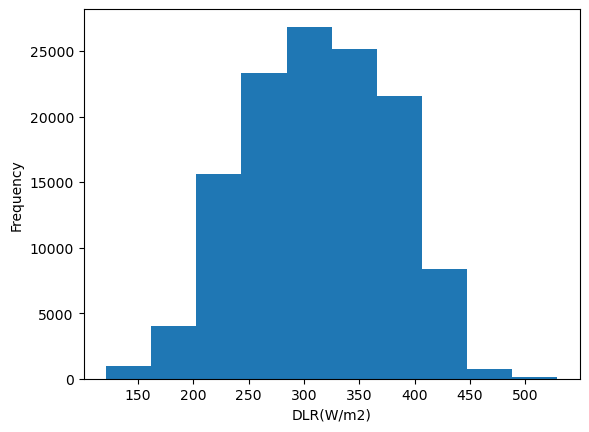

In [9]:
plt.hist(Y)
plt.xlabel('DLR(W/m2)')
plt.ylabel('Frequency')

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3,random_state=6)

In [ ]:
# Train_alldata = data_raw.loc[data_raw.year != 2023]
# Test_alldata = data_raw.loc[data_raw.year == 2023]
# X_train = Train_alldata[features]
# X_test = Test_alldata[features]
# Y_train = Train_alldata[label]
# Y_test = Test_alldata[label]

In [ ]:
# Train_alldata = data_raw.loc[data_raw.elv != 213.0]
# Test_alldata = data_raw.loc[data_raw.elv == 213.0]
# X_train = Train_alldata[features]
# X_test = Test_alldata[features]
# Y_train = Train_alldata[label]
# Y_test = Test_alldata[label]

In [11]:
scaler_input = MinMaxScaler()
scaler_label = MinMaxScaler()

In [12]:
scaler_input.fit(X_train)
scaler_label.fit(Y_train)

MinMaxScaler()

In [13]:
X_train_scaled = scaler_input.transform(X_train)
Y_train_scaled = scaler_label.transform(Y_train)

In [ ]:
plt.hist(X_train_scaled[:,7])
plt.show()

In [14]:
def build_model(hp):
    model = keras.Sequential()

    # first hidden
    model.add(keras.layers.Dense(
        units=hp.Int("units_1", min_value=64, max_value=512, step=64),
        activation="relu",
        input_shape=(X_train.shape[1],)
    ))

    # sencond and third
    if hp.Boolean("use_second_layer"):
        model.add(keras.layers.Dense(
            units=hp.Int("units_2", min_value=32, max_value=256, step=32),
            activation="relu"
        ))
    if hp.Boolean("use_third_layer"):
        model.add(keras.layers.Dense(
            units=hp.Int("units_3", min_value=32, max_value=256, step=32),
            activation="relu"
        ))

    # Dropout 
    model.add(keras.layers.Dropout(
        rate=hp.Float("dropout", 0.1, 0.5, step=0.1)
    ))

    # output
    model.add(keras.layers.Dense(1, activation="linear"))

    # compile
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
        ),
        loss="mse",
        metrics=["mae"]
    )

    return model

In [15]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,
    executions_per_trial=1,
    directory="tuner_dlr",
    project_name="dlr_regression"
)

/Users/yaminguo/anaconda3/envs/keras-tf-v2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(X_train_scaled, Y_train_scaled,
             epochs=50,
             validation_split=0.1,
             validation_split=0.1,
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Trial 20 Complete [00h 00m 16s]
val_loss: 0.0015448646154254675

Best val_loss So Far: 0.001123272581025958
Total elapsed time: 00h 08m 24s


In [34]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

Best hyperparameters:
units_1: 128
use_second_layer: True
use_third_layer: True
dropout: 0.2
learning_rate: 0.0001201370629011427
units_2: 160
units_3: 224


In [35]:

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, Y_train_scaled,
                    epochs=100,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/Users/yaminguo/anaconda3/envs/keras-tf-v2025/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 670us/step - loss: 0.0090 - mae: 0.0689 - val_loss: 0.0018 - val_mae: 0.0329
Epoch 2/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 609us/step - loss: 0.0026 - mae: 0.0400 - val_loss: 0.0017 - val_mae: 0.0318
Epoch 3/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 647us/step - loss: 0.0024 - mae: 0.0378 - val_loss: 0.0017 - val_mae: 0.0307
Epoch 4/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 651us/step - loss: 0.0022 - mae: 0.0361 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 5/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 664us/step - loss: 0.0021 - mae: 0.0350 - val_loss: 0.0015 - val_mae: 0.0293
Epoch 6/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - loss: 0.0019 - mae: 0.0338 - val_loss: 0.0017 - val_mae: 0.0313
Epoch 7/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step - loss: 0.0019 - mae: 0.0331 - val_loss: 0.0015 - val_mae: 0.0287
Epoch 8/100
2495/2495 ━━━━━━━━━━━━━━━━━━━━ 2s 697us/step - loss: 0.0018 - mae: 0.0326 - val_loss: 0.0014 - val_mae: 0.0277
Epoch 9/100
2495/2495 ━━━━━━

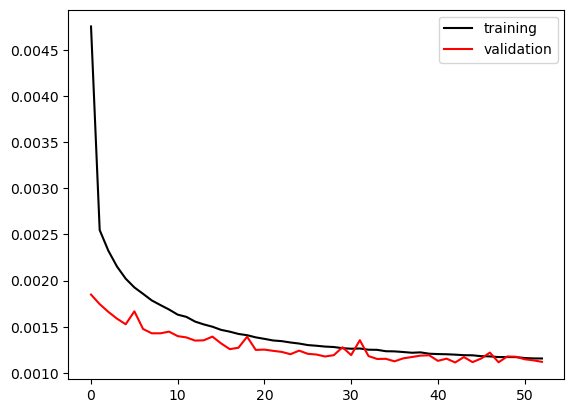

In [36]:
plt.plot(range(0,53), history.history['loss'], c='k', label='training')
plt.plot(range(0,53), history.history['val_loss'], c='r', label='validation')
plt.legend()
plt.show()

Model

In [37]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 160)            │        20,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 224)            │        36,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 176,549 (689.65 KB)

 Trainable params: 58,849 (229.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 117,700 (459.77 KB)

In [39]:
X_test_scaled = scaler_input.transform(X_test)
Y_test_scaled = scaler_label.transform(Y_test)

In [40]:
predictions = model.predict(
    x=X_test_scaled,
)

1189/1189 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step


In [41]:
Pre_inverse=scaler_label.inverse_transform(predictions)
Y_test_inverse=scaler_label.inverse_transform(Y_test_scaled)

In [ ]:
def multipl(a,b):
    sumofab=0.0
    for i in range(len(a)):
        temp=a[i]*b[i]
        sumofab+=temp
    return sumofab
def correlation(x, y):
    n = len(x)
    sum1 = sum(x)
    sum2 = sum(y)
    sumofxy = multipl(x, y)
    sumofx2 = sum([pow(i, 2) for i in x])
    sumofy2 = sum([pow(j, 2) for j in y])
    num = sumofxy - (float(sum1) * float(sum2) / n)
    den = np.sqrt((sumofx2 - float(sum1 ** 2) / n) * (sumofy2 - float(sum2 ** 2) / n))
    r = num / den
    r2 = r * r
    return str('%.2f' % (r2))

def regress(x,y):
    from sklearn import  linear_model
    regr = linear_model.LinearRegression()
    t = np.array(x)
    t = np.array([x]).T
    regr.fit(t, y)
    #k = str('%.2f'%(regr.intercept_))
    #b = str('%.2f'%(regr.coef_))
    k = regr.coef_
    b = regr.intercept_
    KB = [k,b]
    return KB
def RMSE(x, y):
    rmse = np.sqrt(np.mean((x - y) ** 2))
    rmse = round(rmse, 2)
    return str('%.2f' % (rmse))


def MAE(x, y):
    mae = np.mean(abs(x - y))
    # mae = np.mean(x - y)
    mae = round(mae, 2)
    return str('%.2f' % (mae))
def plot_data(ax, x, y, Xmin, Xmax, Ymin, Ymax, Xinter, Yinter,Lables):
    from matplotlib.colors import LogNorm
    # z_min = 0
    # z_max = 500
    nbins = 100
    # global plot
    H, xedges, yedges = np.histogram2d(x, y, bins=nbins)
    H = np.rot90(H)
    H = np.flipud(H)
    # H_freq = H / H.sum()
    Hmasked = np.ma.masked_where(H == 0, H)  # Mask pixels with a value of zero
    z_min_dynamic = Hmasked.min()
    z_max_dynamic = Hmasked.max()
    z_min = z_min_dynamic
    z_min = np.percentile(Hmasked.compressed(), 5)
    z_max = np.percentile(Hmasked.compressed(), 95)
    # norm = LogNorm(vmin=z_min, vmax=z_max)
    plot = ax.pcolormesh(xedges, yedges, Hmasked, cmap='jet', vmin=z_min, vmax=z_max)
    cbar = plt.colorbar(plot, ax=ax)
    # plot = ax.pcolormesh(xedges, yedges, Hmasked, cmap='jet', norm = LogNorm(vmin=z_min, vmax=z_max))
    # pt.colorbar()
    # cbar.ax.set_yticklabels(('0', '1', '2', '3', '4','5','6','7','8','9','10'),fontname='Calibri',fontsize=14,fontweight='bold')
    # cbar.ax.set_ylabel('Frequency')

    # y=x
    xx = [Xmin, Xmax]
    yy = [Xmin, Xmax]
    ax.plot(xx, yy, 'k--', linewidth=2.)

    aa = regress(x, y)
    ax.plot(x, x * aa[0] + aa[1], 'r', linewidth=1.)
    k = str('%.2f' % (aa[0]))
    b = str('%.2f' % (aa[1]))
    ax.set_ylim(Ymin, Ymax)
    ax.set_xlim(Xmin, Xmax)
    my_x_ticks = np.arange(Xmin, Xmax + Xinter, Xinter)
    my_y_ticks = np.arange(Ymin, Ymax + Yinter, Yinter)
    ax.set_xticks(my_x_ticks)
    ax.set_yticks(my_y_ticks)
    ax.set_xlabel(Lables[0], fontname='Calibri', fontsize=16)
    ax.set_ylabel(Lables[1], fontname='Calibri', fontsize=16)

    ax.set_xlabel(Lables[0], fontname='Calibri', fontsize=16)
    ax.set_ylabel(Lables[1], fontname='Calibri', fontsize=16)
    ax.text(Xmin + Xinter / 3, Ymax - Yinter / 3, r"N = " + str(len(x)),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 2 * Yinter / 3, r"R$^2$ = " + correlation(x, y),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 3 * Yinter / 3, r"RMSE = " + RMSE(x, y),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 4 * Yinter / 3, r"MAE = " + MAE(x, y),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin + Xinter / 3, Ymax - 5 * Yinter / 3, r"Y = " + k + " X + " + b,
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.set_title(Lables[2])
    # plt.colorbar()
    result = [len(x), correlation(x, y), RMSE(x, y), MAE(x, y), k, b]
    return result
def scatterplot(ax, Xdata, Ydata, Xmin, Xmax, Ymin, Ymax, Xinter, Yinter,Lables):
    from scipy.stats import gaussian_kde
    xy = np.vstack([Xdata, Ydata])  # 
    z = gaussian_kde(xy)(xy)  # 
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    x, y, z = Xdata[idx], Ydata[idx], z[idx]

    plt.scatter(x, y, c=z, s=10, cmap='jet')  # 
    xx = [Xmin, Xmax]
    yy = [Xmin, Xmax]
    ax.plot(xx, yy, 'k--', linewidth=0.5)
    aa = regress(x, y)
    # ax.plot(x, x * aa[0] + aa[1], 'k', linewidth=0.5)
    k = str('%.2f' % (aa[0]))
    b = str('%.2f' % (aa[1]))
    ax.set_ylim(Ymin, Ymax)
    ax.set_xlim(Xmin, Xmax)
    my_x_ticks = np.arange(Xmin, Xmax + Xinter, Xinter)
    my_y_ticks = np.arange(Ymin, Ymax + Yinter, Yinter)
    ax.set_xticks(my_x_ticks)
    ax.set_yticks(my_y_ticks)
    # ax.set_xticklabels(('0', '5', '10', '15', '20'), fontname='Calibri', fontsize=16)
    # ax.set_yticklabels(('0', '5', '10', '15', '20'), fontname='Calibri', fontsize=16)
    ax.set_xlabel(Lables[0], fontname='Calibri', fontsize=16)
    ax.set_ylabel(Lables[1], fontname='Calibri', fontsize=16)
    ax.text(Xmin+Xinter/3, Ymax-Yinter/3, r"N = " + str(len(Xdata)),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter/3, Ymax-2*Yinter/3, r"R$^2$ = " + correlation(Xdata, Ydata),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter/3, Ymax-3*Yinter/3, r"RMSE = " + RMSE(Xdata, Ydata),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter/3, Ymax-4*Yinter/3, r"MAE = " + MAE(Xdata, Ydata),
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.text(Xmin+Xinter / 3, Ymax - 5 * Yinter / 3, r"Y = "+k+" X + "+b,
            {'color': 'k', 'fontname': 'Calibri', 'fontsize': 14, 'fontweight': 'bold'})
    ax.set_title(Lables[2])
    plt.colorbar()
    result=[len(Xdata),correlation(Xdata, Ydata),RMSE(Xdata, Ydata),MAE(Xdata, Ydata),k,b]
    return result

In [43]:
Y_test_inverse2=Y_test_inverse.reshape(-1)
Pre_inverse2=Pre_inverse.reshape(-1)

/var/folders/n1/zydkpbg91lb27p4jtp0w1q340000gq/T/ipykernel_85803/304093471.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = str('%.2f' % (aa[0]))
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'C

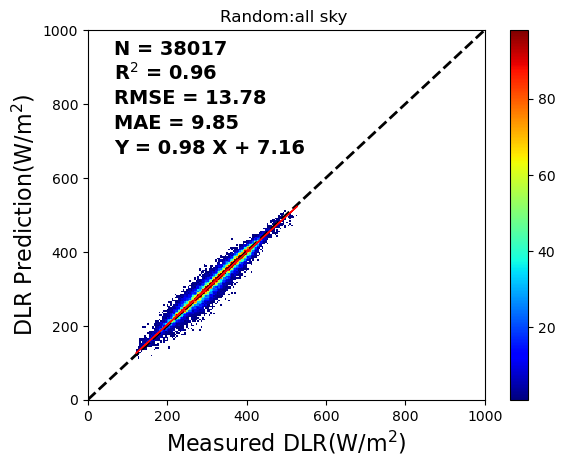

In [44]:
fig, ax = plt.subplots()
result_sites=plot_data(ax, Y_test_inverse2, Pre_inverse2,0, 1000, 0, 1000, 200, 200, ['Measured DLR(W/m$^2$)', 'DLR Prediction(W/m$^2$)', 'Random'+ ':all sky '])


In [ ]:
model.save('ann_model_DLR.h5')

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
87/87 ━━━━━━━━━━

PermutationExplainer explainer:  16%|█▌        | 8/50 [00:00<?, ?it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step


PermutationExplainer explainer:  20%|██        | 10/50 [00:11<00:21,  1.83it/s]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 360us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


PermutationExplainer explainer:  22%|██▏       | 11/50 [00:12<00:30,  1.30it/s]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 351us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


PermutationExplainer explainer:  24%|██▍       | 12/50 [00:13<00:32,  1.16it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


PermutationExplainer explainer:  26%|██▌       | 13/50 [00:14<00:32,  1.13it/s]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step


PermutationExplainer explainer:  28%|██▊       | 14/50 [00:15<00:33,  1.08it/s]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step


PermutationExplainer explainer:  30%|███       | 15/50 [00:16<00:33,  1.05it/s]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


PermutationExplainer explainer:  32%|███▏      | 16/50 [00:17<00:32,  1.04it/s]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step


PermutationExplainer explainer:  34%|███▍      | 17/50 [00:18<00:31,  1.04it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


PermutationExplainer explainer:  36%|███▌      | 18/50 [00:19<00:30,  1.04it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


PermutationExplainer explainer:  38%|███▊      | 19/50 [00:20<00:30,  1.01it/s]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 362us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


PermutationExplainer explainer:  40%|████      | 20/50 [00:21<00:30,  1.00s/it]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 307us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


PermutationExplainer explainer:  42%|████▏     | 21/50 [00:22<00:28,  1.02it/s]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step


PermutationExplainer explainer:  44%|████▍     | 22/50 [00:23<00:27,  1.04it/s]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step


PermutationExplainer explainer:  46%|████▌     | 23/50 [00:24<00:26,  1.03it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 310us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


PermutationExplainer explainer:  48%|████▊     | 24/50 [00:25<00:25,  1.02it/s]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step


PermutationExplainer explainer:  50%|█████     | 25/50 [00:26<00:24,  1.02it/s]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 309us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


PermutationExplainer explainer:  52%|█████▏    | 26/50 [00:27<00:23,  1.02it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


PermutationExplainer explainer:  54%|█████▍    | 27/50 [00:28<00:22,  1.01it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


PermutationExplainer explainer:  56%|█████▌    | 28/50 [00:29<00:21,  1.01it/s]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


PermutationExplainer explainer:  58%|█████▊    | 29/50 [00:30<00:20,  1.01it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step


PermutationExplainer explainer:  60%|██████    | 30/50 [00:31<00:20,  1.00s/it]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step


PermutationExplainer explainer:  62%|██████▏   | 31/50 [00:32<00:18,  1.01it/s]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  64%|██████▍   | 32/50 [00:33<00:17,  1.01it/s]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


PermutationExplainer explainer:  66%|██████▌   | 33/50 [00:34<00:16,  1.01it/s]

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 314us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step


PermutationExplainer explainer:  68%|██████▊   | 34/50 [00:35<00:15,  1.01it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step


PermutationExplainer explainer:  70%|███████   | 35/50 [00:36<00:14,  1.02it/s]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


PermutationExplainer explainer:  72%|███████▏  | 36/50 [00:37<00:13,  1.01it/s]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step


PermutationExplainer explainer:  74%|███████▍  | 37/50 [00:38<00:12,  1.01it/s]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 403us/step


PermutationExplainer explainer:  76%|███████▌  | 38/50 [00:39<00:11,  1.02it/s]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step


PermutationExplainer explainer:  78%|███████▊  | 39/50 [00:40<00:10,  1.02it/s]

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step


PermutationExplainer explainer:  80%|████████  | 40/50 [00:41<00:09,  1.01it/s]

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step


PermutationExplainer explainer:  82%|████████▏ | 41/50 [00:42<00:08,  1.00it/s]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step


PermutationExplainer explainer:  84%|████████▍ | 42/50 [00:43<00:07,  1.01it/s]

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 370us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step


PermutationExplainer explainer:  86%|████████▌ | 43/50 [00:44<00:06,  1.03it/s]

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 354us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


PermutationExplainer explainer:  88%|████████▊ | 44/50 [00:45<00:05,  1.01it/s]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 340us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 352us/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


PermutationExplainer explainer:  90%|█████████ | 45/50 [00:46<00:04,  1.00it/s]

83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


PermutationExplainer explainer:  92%|█████████▏| 46/50 [00:47<00:03,  1.01it/s]

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 344us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step


PermutationExplainer explainer:  94%|█████████▍| 47/50 [00:48<00:03,  1.01s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 359us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 334us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 336us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 328us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 397us/step


PermutationExplainer explainer:  96%|█████████▌| 48/50 [00:49<00:01,  1.00it/s]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 342us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step


PermutationExplainer explainer:  98%|█████████▊| 49/50 [00:50<00:00,  1.00it/s]

85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 326us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 327us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 324us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


PermutationExplainer explainer: 100%|██████████| 50/50 [00:51<00:00,  1.00s/it]

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 346us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 341us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 349us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 345us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 355us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 338us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 350us/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step


PermutationExplainer explainer: 51it [00:52,  1.22s/it]                        


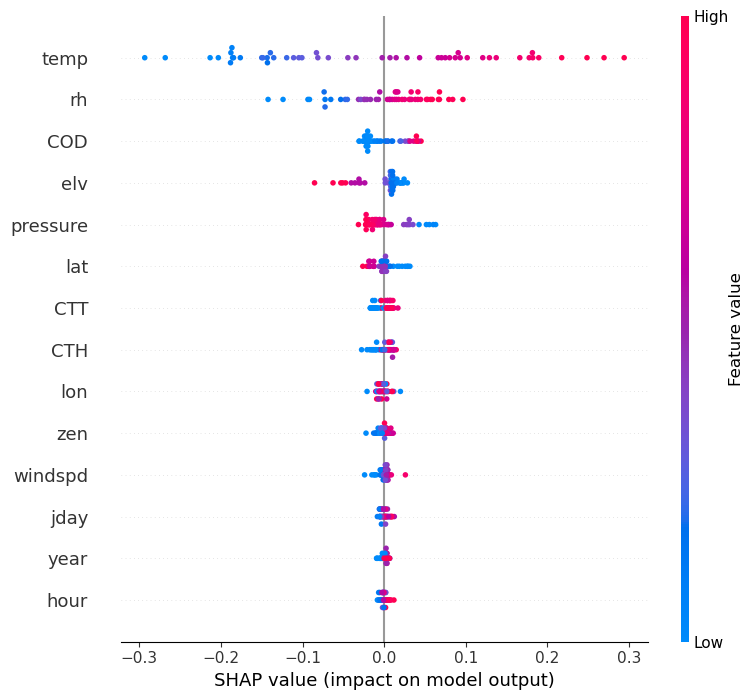

In [48]:
import shap

explainer = shap.Explainer(model.predict, X_train_scaled[:100])
shap_values = explainer(X_train_scaled[:50])

shap.summary_plot(shap_values, X_train_scaled[:50], feature_names=features)